Reference - this code is just modification of https://github.com/dennybritz/reinforcement-learning

In [1]:
%run ../utils/commonImports.py
%run ../utils/tradingImports.py
%matplotlib inline

In [2]:
import gym
import itertools
import matplotlib
import sys
import tensorflow as tf
import collections

matplotlib.style.use('ggplot')

In [28]:
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_cost_to_go_mountain_car(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))



def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    return fig2

# Load Data

In [4]:
dataRoot = 'D:\\Dropbox\\My work\\krypl-project\\dataFeatures\\poloniex\\5min'
fileName = 'USDT_BTC_5min_2016-01-01_2017-12-31.tsv'
file = '{dataRoot}\\{fileName}'.format(dataRoot=dataRoot, fileName=fileName)

usdtBtc = pd.read_csv(file, sep='\t').query("date >= '2017-01-01'")\
    .sort_values('date').reset_index().drop('index', axis=1)
usdtBtc = usdtBtc

trainRatio = 0.7
trainSize = int(usdtBtc.shape[0] * trainRatio)
usdtBtcTrain = usdtBtc.iloc[:trainSize]
usdtBtcTest = usdtBtc.iloc[trainSize:].reset_index().drop('index', axis=1)

usdtBtcManagerTrain = CurrencyDataManager(usdtBtcTrain['close'], usdtBtcTrain)
usdtBtcManagerTest = CurrencyDataManager(usdtBtcTest['close'], usdtBtcTest)
wallet = {'usdt': 1000}
contractPair = ContractPair.new('usdt', 'btc')

In [5]:
dataManager = deepcopy(usdtBtcManagerTrain)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)

# Dummy Estimators

Just to test learning performance

In [6]:
class DummyPolicyEstimator:
    def predict(self, state):
        return [0.7, 0.1, 0.2] 
    
    def update(self, state, target, action):
        pass

    
class DummyValueEstimator:
    def predict(self, state):
        return 0
    
    def update(self, state, target):
        pass

# Reinforce

In [7]:
usdtBtcTrain.columns

Index(['date', 'close', 'return', 'return_1', 'return_2', 'zscore_36_return',
       'zscore_288_return', 'pma36', 'ma_12_108', 'ma_36_288', 'ac36', 'ac288',
       'zscore_36_volume', 'zscore_288_volume', 'zscore_2016_volume', 'vol36',
       'vol288', 'vol2016', 'dv_36_288'],
      dtype='object')

In [9]:
from modeling.rl.enviroment import ExchangeEnv
from modeling.rl.estimator import PerceptronPolicyEstimator, PerceptronValueEstimator

# cols = ['close', 'return', 'return_1', 'return_2', 'zscore_36_return', 'zscore_288_return']

env = ExchangeEnv(
    data=usdtBtcTrain.drop('date', axis=1),
    price_col='close',
    pair=contractPair,
    wallet=wallet,
    fee=0.0025,
    epoch_len=288,
    trade_amount=100
)

In [10]:
def getState(envState):
    return envState

In [11]:
def reinforce(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done", "debug"])
    episodes = []
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = getState(env.reset())
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, debug = env.step(action)
            next_state = getState(next_state)
            # Keep track of the transition
            episode.append(Transition(state=state, action=action, reward=reward, next_state=next_state, done=done, debug=debug))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            # sys.stdout.flush()

            if done:
                break
                
            state = next_state
            
        episodes.append(episode)
    
        # Go through the episode and make policy updates
        for t, transition in enumerate(episode):
            # The return after this timestep
            total_return = sum(discount_factor**i * t.reward for i, t in enumerate(episode[t:]))
            # Calculate baseline/advantage
            baseline_value = estimator_value.predict(transition.state)            
            advantage = total_return - baseline_value
            # Update our value estimator
            estimator_value.update(transition.state, total_return)
            # Update our policy estimator
            estimator_policy.update(transition.state, advantage, transition.action)
    
    return stats, episodes

In [15]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PerceptronPolicyEstimator(env.observation_space.n, env.action_space.n)
value_estimator = PerceptronValueEstimator(env.observation_space.n)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    stats, episodes = reinforce(env, policy_estimator, value_estimator, 100, discount_factor=1.0)

Step 286 @ Episode 100/100 (-8.298131199928315)

C:\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [34]:
tf.Session()

In [33]:
%%time
sess.run(tf.initialize_all_variables())
stats, episodes = reinforce(env, policy_estimator, value_estimator, 100, discount_factor=1.0)

AttributeError: 'NoneType' object has no attribute 'run'

In [24]:
episode_stats = pd.DataFrame(episodes[-1])
for k in episode_stats['debug'].values[0].keys():
    episode_stats[k] = episode_stats['debug'].apply(lambda x: x[k])

In [25]:
episode_stats

,state,action,reward,next_state,done,debug,initial_wallet,current_value,err,initial_value,current_wallet
0,"[[-0.001947628357096054, -0.001767441851179385...",0,0.0000,"[[-0.0028094975303424308, -0.00194762835709605...",False,"{'initial_wallet': {'usdt': 1000}, 'current_va...",{'usdt': 1000},"1,000.0000",False,"1,000.0000","{'usdt': 976.0463767348451, 'btc': 0.0}"
1,"[[-0.0028094975303424308, -0.00194762835709605...",0,0.0000,"[[-9.363755277824736e-07, -0.00280949753034243...",False,"{'initial_wallet': {'usdt': 1000}, 'current_va...",{'usdt': 1000},"1,000.0000",False,"1,000.0000","{'usdt': 976.0463767348451, 'btc': 0.0}"
2,"[[-9.363755277824736e-07, -0.00280949753034243...",0,0.0000,"[[0.002067618623576406, -9.363755277824736e-07...",False,"{'initial_wallet': {'usdt': 1000}, 'current_va...",{'usdt': 1000},"1,000.0000",False,"1,000.0000","{'usdt': 976.0463767348451, 'btc': 0.0}"
3,"[[0.002067618623576406, -9.363755277824736e-07...",0,0.0000,"[[-0.004290154923457522, 0.002067618623576406,...",False,"{'initial_wallet': {'usdt': 1000}, 'current_va...",{'usdt': 1000},"1,000.0000",False,"1,000.0000","{'usdt': 976.0463767348451, 'btc': 0.0}"
4,"[[-0.004290154923457522, 0.002067618623576406,...",0,0.0000,"[[-0.0005788737720987536, -0.00429015492345752...",False,"{'initial_wallet': {'usdt': 1000}, 'current_va...",{'usdt': 1000},"1,000.0000",False,"1,000.0000","{'usdt': 976.0463767348451, 'btc': 0.0}"
5,"[[-0.0005788737720987536, -0.00429015492345752...",1,-0.0002,"[[0.0, -0.0005788737720987536, -0.004290154923...",False,"{'initial_wallet': {'usdt': 1000}, 'current_va...",{'usdt': 1000},999.7500,False,"1,000.0000","{'usdt': 976.0463767348451, 'btc': 0.0}"
6,"[[0.0, -0.0005788737720987536, -0.004290154923...",0,0.0002,"[[6.572764554846344e-11, 0.0, -0.0005788737720...",False,"{'initial_wallet': {'usdt': 1000}, 'current_va...",{'usdt': 1000},999.7500,False,"1,000.0000","{'usdt': 976.0463767348451, 'btc': 0.0}"
7,"[[6.572764554846344e-11, 0.0, -0.0005788737720...",0,0.0002,"[[0.004694835154620991, 6.572764554846344e-11,...",False,"{'initial_wallet': {'usdt': 1000}, 'current_va...",{'usdt': 1000},"1,000.2195",False,"1,000.0000","{'usdt': 976.0463767348451, 'btc': 0.0}"
8,"[[0.004694835154620991, 6.572764554846344e-11,...",1,-0.0000,"[[2.990654390799818e-10, 0.004694835154620991,...",False,"{'initial_wallet': {'usdt': 1000}, 'current_va...",{'usdt': 1000},999.9695,False,"1,000.0000","{'usdt': 976.0463767348451, 'btc': 0.0}"
9,"[[2.990654390799818e-10, 0.004694835154620991,...",1,-0.0011,"[[1.682243233602776e-10, 2.990654390799818e-10...",False,"{'initial_wallet': {'usdt': 1000}, 'current_va...",{'usdt': 1000},999.7195,False,"1,000.0000","{'usdt': 976.0463767348451, 'btc': 0.0}"


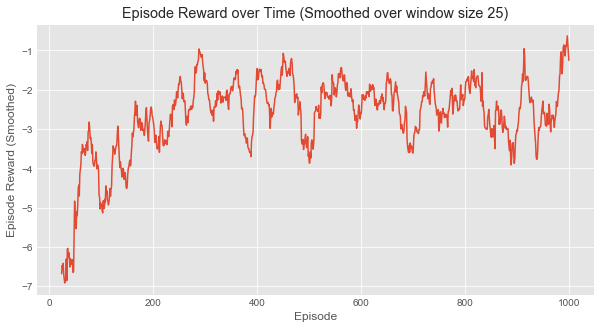

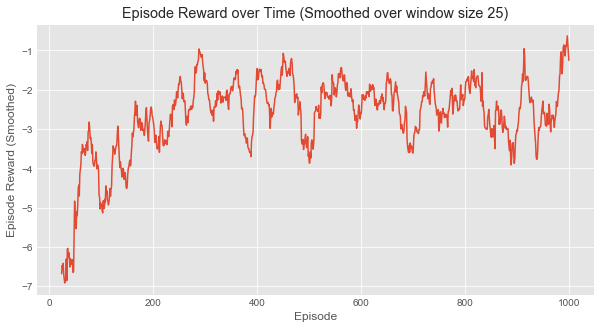

In [31]:
plot_episode_stats(stats, smoothing_window=25)